# Posprocessing a run

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.6

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.6


In [3]:
import lenses
import jax
from jax import numpy as jnp
from typing import cast
import matplotlib.pyplot as plt

from flox.util import key_chain
from flox.flow import Pipe, Inverted, bind#, Transform, Transformed
import equinox as eqx

from rigid_flows.flow import build_flow, RigidWithAuxiliary
from rigid_flows.data import Data, DataWithAuxiliary
from rigid_flows.density import OpenMMDensity
from rigid_flows.specs import FlowSpecification, CouplingSpecification, ExperimentSpecification
# from rigid_flows.density import PositionPrior, RotationPrior
from rigid_flows.utils import jit_and_cleanup_cache, scanned_vmap

chain = key_chain(42)

2023-01-24 15:43:41.009769: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-01-24 15:43:41.009966: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-01-24 15:43:41.009980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
def count_params(model):
    return jax.tree_util.tree_reduce(
        lambda s, n: s + n.size if eqx.is_array(n) else s, model, jnp.zeros((), dtype=jnp.int32)).item()

hist_kwargs = {"bins": "auto", "density": True, "alpha": 0.5}

In [5]:
logdir_path = 'jonas_logdir/'
# logdir_path += 'tuna_N16_new_2023-01-24_14:49:06'
logdir_path += 'tuna_test_new_2023-01-24_15:41:40'
stage = 0
epoch = 9
print(f'+++ epoch {epoch} +++')
specs_path = f"{logdir_path}/config.yaml"
pretrained_model_path = f'{logdir_path}/training_stage_{stage}/epoch_{epoch}/model.eqx'


specs = ExperimentSpecification.load_from_file(specs_path)
specs = lenses.bind(specs).model.base.path.set(specs.model.base.path+'/eval_100')

base = OpenMMDensity.from_specs(specs.model.auxiliary_shape, specs.model.base)
target = OpenMMDensity.from_specs(specs.model.auxiliary_shape, specs.model.target)
model = base.omm_model.model

data = Data.from_specs(specs.model.target, target.box)
flow = build_flow(next(chain), specs.model.auxiliary_shape, specs.model.flow)
flow = cast(Pipe[DataWithAuxiliary, RigidWithAuxiliary], eqx.tree_deserialise_leaves(pretrained_model_path, flow))

training_data_size = 100_000 if specs.model.base.num_samples is None else specs.model.base.num_samples
print(f'tot flow parameters: {count_params(flow):_}')
print(f'MD training datapoints = {training_data_size:_}')
print(f'MD eval datapoints = {base.data.pos.shape[0]:_}')
print(f'batchs per epoch = {specs.train[0].num_iters_per_epoch}')
print(f'batch size = {specs.train[0].num_samples}')
print(f'data fraction: {specs.train[0].num_epochs*specs.train[0].num_samples*specs.train[0].num_iters_per_epoch/training_data_size}')

+++ epoch 0 +++
tot flow parameters: 61_280
MD training datapoints = 100_000
MD eval datapoints = 100_000
batchs per epoch = 1000
batch size = 32
data fraction: 0.32


In [6]:
reference_deltaF, reference_deltaF_std = None, None

if specs.model.base.temperature == specs.model.target.temperature:
    reference_deltaF, reference_deltaF_std = 0, 0
elif specs.model.base.num_molecules == 16:
    if specs.model.base.temperature == 250 and specs.model.target.temperature == 100:
        reference_deltaF, reference_deltaF_std = -666.09897990553, 0.0558899 # MBAR, 10_000 samples, 5 replicas
    elif specs.model.base.temperature == 250 and specs.model.target.temperature == 50:
        reference_deltaF, reference_deltaF_std = -1818.2199636389134, 0.0632776 # MBAR, 10_000 samples, 10 replicas
elif specs.model.base.num_molecules == 128:
    if specs.model.base.temperature == 250 and specs.model.target.temperature == 100:
        reference_deltaF, reference_deltaF_std = -5314.324317927606, 0.0944014 # MBAR, 10_000 samples, 10 replicas
    elif specs.model.base.temperature == 250 and specs.model.target.temperature == 50:
        reference_deltaF, reference_deltaF_std = -14522.10556489954, 0.135 # MBAR, 10_000 samples, 20 replicas

reference_deltaF, reference_deltaF_std

(-666.09897990553, 0.0558899)

In [7]:
num_samples = 10_000
batch_size = 128

keys = jax.random.split(next(chain), num_samples)
base_tr = jax.vmap(base.sample)(keys)

mapped_tr = scanned_vmap(flow.forward, batch_size)(base_tr.obj)

keys = jax.random.split(next(chain), num_samples)
target_tr = jax.vmap(target.sample)(keys)

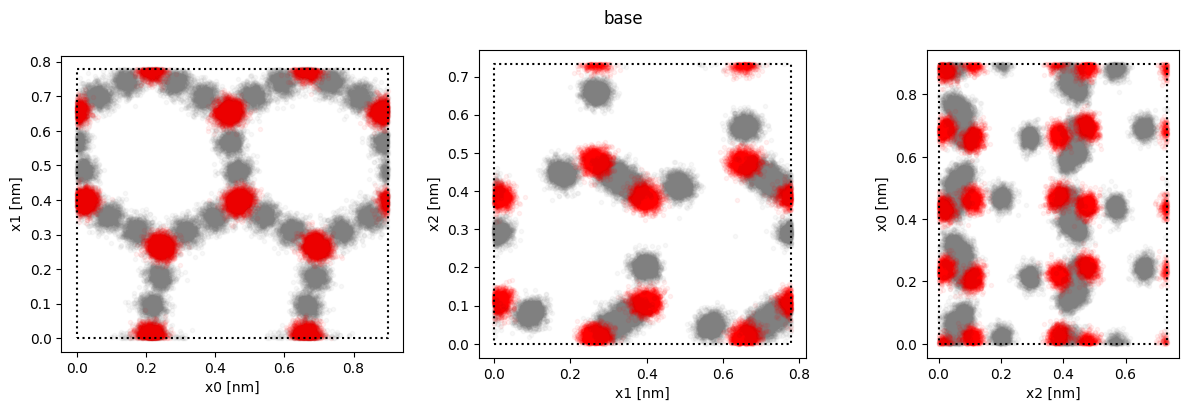

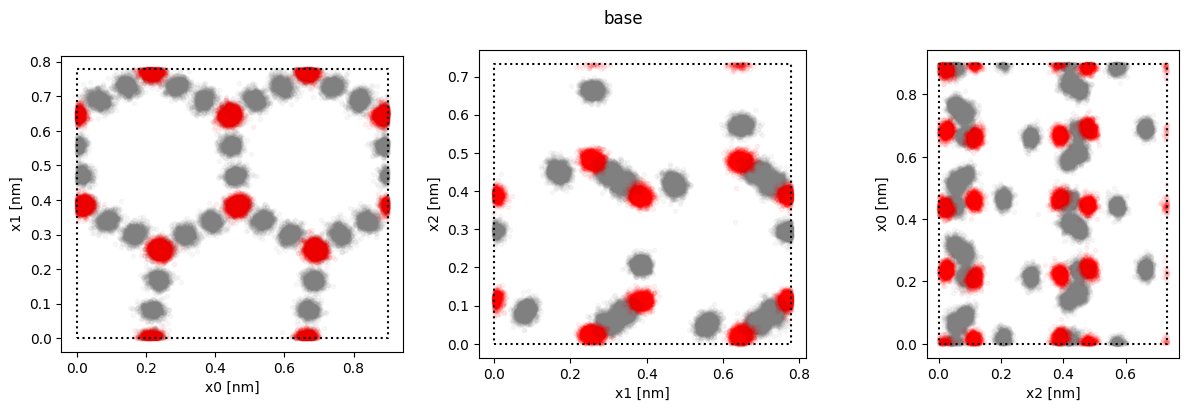

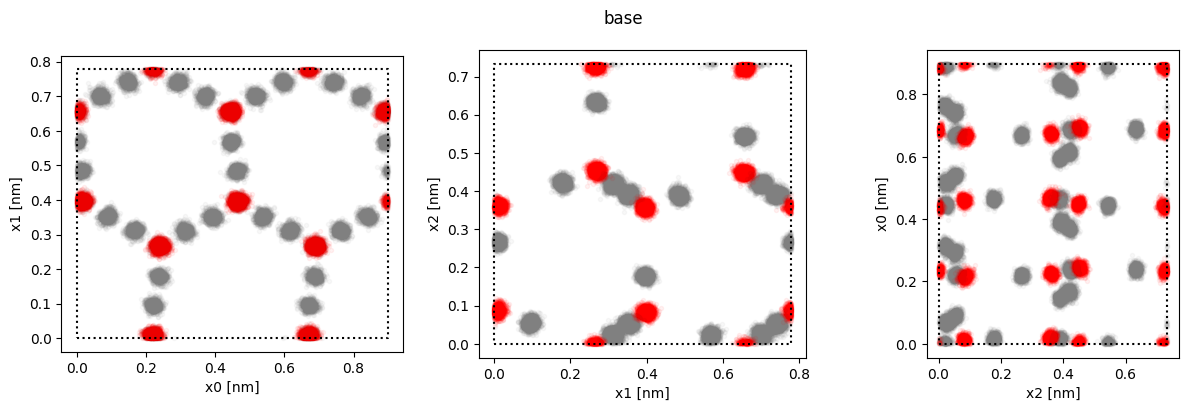

In [8]:
def plot_2Dview(data_tr: DataWithAuxiliary, title: str, toPBC: bool = True, skip: int = 10):
    model.plot_2Dview(data_tr.obj.pos.reshape(-1, model.n_atoms, 3)[::skip], toPBC=toPBC, title=title)

plot_2Dview(base_tr, title='base')
plot_2Dview(mapped_tr, title='base')
plot_2Dview(target_tr, title='base')

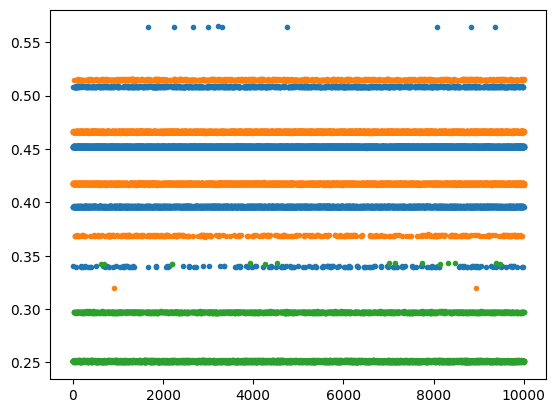

In [9]:
## closer look at the center of mass
com_pos = mapped_tr.obj.pos.mean(axis=(1,2))
plt.plot(com_pos, '.')
plt.show()

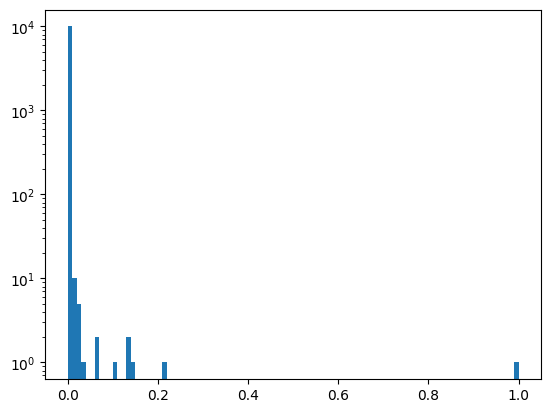

ESS = 5.39738  ->  0.05%


In [10]:
def ess(logw):
    return jnp.exp(2*jax.scipy.special.logsumexp(logw)-jax.scipy.special.logsumexp(2*logw))

## NB: base_tr.ldj = jax.vmap(base.potential)(base_tr.obj)
logw = base_tr.ldj + mapped_tr.ldj - jax.vmap(target.potential)(mapped_tr.obj)

plt.hist(jnp.exp(logw-logw.max()), bins=100)
plt.yscale('log')
plt.show()

print(f'ESS = {ess(logw):g}  ->  {ess(logw)/len(logw):.2%}')

In [11]:
ene_fn = jax.vmap(target.potential)
base_ene = ene_fn(base_tr.obj)
mapped_ene = ene_fn(mapped_tr.obj)
target_ene = ene_fn(target_tr.obj)

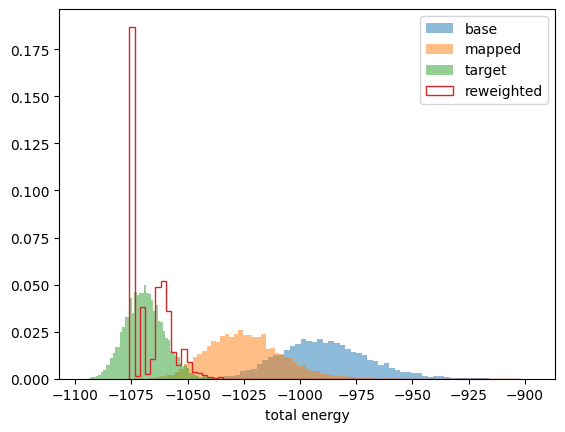

In [12]:
plt.hist(base_ene, **hist_kwargs, label='base')
plt.hist(mapped_ene, **hist_kwargs, label='mapped')
plt.hist(target_ene, **hist_kwargs, label='target')
plt.hist(mapped_ene, weights=jnp.exp(logw-jax.scipy.special.logsumexp(logw)), bins=75, histtype='step', density=True, label='reweighted')
plt.xlabel('total energy')
plt.legend()
plt.show()

In [13]:
ene_label = 'omm'
scaling = 1
if ene_label == 'omm':
    scaling = target.omm_model.kbT
base_ene2 = target.compute_energies(base_tr.obj, True, False, True)[ene_label] * scaling
target_ene2 = target.compute_energies(target_tr.obj, True, False, True)[ene_label] * scaling
mapped_ene2 = target.compute_energies(mapped_tr.obj, True, False, True)[ene_label] * scaling

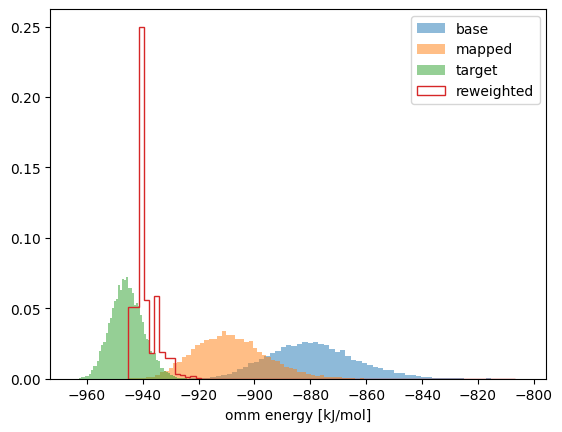

In [14]:
plt.hist(base_ene2, **hist_kwargs, label='base')
plt.hist(mapped_ene2, **hist_kwargs, label='mapped')
plt.hist(target_ene2, **hist_kwargs, label='target')
plt.hist(mapped_ene2, weights=jnp.exp(logw-jax.scipy.special.logsumexp(logw)), bins=75, histtype='step', density=True, label='reweighted')
plt.xlabel(ene_label + ' energy [kJ/mol]') #it's kJ/mol only for omm energies
plt.legend()
plt.show()

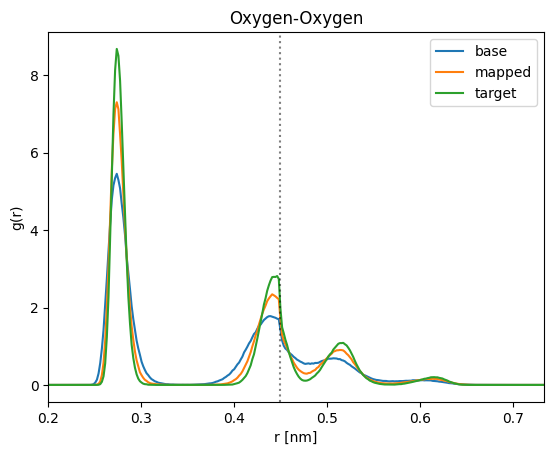

In [15]:
#TODO add reweighted rdf

r_range = [0.2, np.diag(model.box).min()]
n_bins = 300
plt.title('Oxygen-Oxygen')
model.plot_rdf(base_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='base')
model.plot_rdf(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='mapped')
model.plot_rdf(target_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='target')
plt.axvline(model.box.max()/2, c='k', ls=':', alpha=.5)
plt.legend()
plt.show()

In [16]:
## TFEP
deltaF = (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw)).item()
print(f'Estimated deltaF from LFEP = {deltaF:g}')
if reference_deltaF is not None:
    print(f'          Reference deltaF = {reference_deltaF:g}')

Estimated deltaF from LFEP = -663.489
          Reference deltaF = -666.099


In [17]:
from functools import partial

@partial(jax.jit, static_argnames=["num_samples", "base", "batch_size"])
def estimate_deltaF(key, num_samples, base=base, batch_size=128):
    keys = jax.random.split(key, num_samples)
    base_tr = jax.vmap(base.sample)(keys)
    mapped_tr = scanned_vmap(flow.inverse, batch_size)(base_tr.obj)
    logw = base_tr.ldj + mapped_tr.ldj - jax.vmap(target.potential)(mapped_tr.obj)
    return (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw))

In [18]:
estimate_from_training = False #this gives a biased estimate, always lower

from tqdm import trange

iterations = 10
num_samples = base.data.pos.shape[0]

deltaFs = np.zeros(iterations)
for i in trange(iterations):
    deltaFs[i] = estimate_deltaF(next(chain), num_samples)
    print(deltaFs[i])
print(f'deltaF = {deltaFs.mean():g} +/- {deltaFs.std():g}')

  0%|          | 0/10 [00:00<?, ?it/s]2023-01-24 15:46:14.367927: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2163] Execution of replica 0 failed: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  <__array_function__ internals>(200): empty_like
  /srv/data/minvernizzi/notebook/water/rigid-flows/rigid_flows/system.py(152): compute_energies_and_forces
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/jax/_src/callback.py(124): _flat_callback
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/jax/_src/callback.py(41): pure_callback_impl
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/jax/_src/callback.py(104): _callback
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/jax/interpreters/mlir.py(1765): _wrapped_callback
  /home/mi/minverni

XlaRuntimeError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  <__array_function__ internals>(200): empty_like
  /srv/data/minvernizzi/notebook/water/rigid-flows/rigid_flows/system.py(152): compute_energies_and_forces
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/jax/_src/callback.py(124): _flat_callback
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/jax/_src/callback.py(41): pure_callback_impl
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/jax/_src/callback.py(104): _callback
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/jax/interpreters/mlir.py(1765): _wrapped_callback
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/jax/interpreters/pxla.py(2136): __call__
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/jax/_src/profiler.py(314): wrapper
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/jax/_src/api.py(623): cache_miss
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/jax/_src/traceback_util.py(162): reraise_with_filtered_traceback
  /tmp/ipykernel_2177111/360902634.py(10): <module>
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3442): run_code
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3382): run_ast_nodes
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3203): run_cell_async
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3000): _run_cell
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/IPython/core/interactiveshell.py(2945): run_cell
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/ipykernel/zmqshell.py(540): run_cell
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/ipykernel/ipkernel.py(417): do_execute
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/ipykernel/kernelbase.py(731): execute_request
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/ipykernel/kernelbase.py(408): dispatch_shell
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/ipykernel/kernelbase.py(501): process_one
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/ipykernel/kernelbase.py(512): dispatch_queue
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/asyncio/events.py(80): _run
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/asyncio/base_events.py(1899): _run_once
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/asyncio/base_events.py(603): run_forever
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/tornado/platform/asyncio.py(215): start
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/ipykernel/kernelapp.py(724): start
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/traitlets/config/application.py(1041): launch_instance
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/site-packages/ipykernel_launcher.py(17): <module>
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/runpy.py(86): _run_code
  /home/mi/minvernizzi/miniconda3/envs/flox/lib/python3.10/runpy.py(196): _run_module_as_main
.

In [ ]:
# @partial(jax.jit, static_argnames=["start", "num_samples", "base", "batch_size"])
# def estimate_deltaF_idx(key, start, num_samples, base=base, batch_size=128):
#     keys = jax.random.split(key, num_samples)
#     base_tr = jax.vmap(base.sample_idx)(keys, jnp.arange(start, start+num_samples))
#     mapped_tr = scanned_vmap(flow.inverse, batch_size)(base_tr.obj)
#     logw = base_tr.ldj + mapped_tr.ldj - jax.vmap(target.potential)(mapped_tr.obj)
#     return (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw))

# deltaFs = np.zeros(iterations)
# for i in trange(iterations):
#     deltaFs[i] = estimate_deltaF_idx(next(chain), i*num_samples, num_samples)
#     print(deltaFs[i])
# print(f'deltaF = {deltaFs.mean():g} +/- {deltaFs.std():g}')

In [ ]:
xlim = [0, len(deltaFs)]
plt.plot(deltaFs, '.', c='orange', label='LFEP')
x = 2 * [deltaFs.mean()]
plt.fill_between(xlim, x-deltaFs.std(), x+deltaFs.std(), color='orange', alpha=0.3)
plt.axhline(deltaFs.mean(), c='orange')
if reference_deltaF is not None:
    plt.axhline(reference_deltaF, c='k', ls=":", label='MBAR reference')
    x = np.array(2 * [reference_deltaF])
    plt.fill_between(xlim, x-reference_deltaF_std, x+reference_deltaF_std, color='k', alpha=0.1)
plt.xlim(xlim)
plt.legend()
plt.show()

In [ ]:
deltaFs.mean()-reference_deltaF